In [ ]:
# Imports
import pickle

In [6]:
# Vars
skymap_path = "/sdf/home/o/olynn/LINCC/Skymaps/skyMap_lsst_cells_v1_skymaps.pickle"

In [7]:
with open(skymap_path, "rb") as f:
    skymap_data = pickle.load(f)
    print(skymap_data)

In [5]:
import lsst.skymap

In [9]:
import lsst.geom as geom

def reportSkyMapInfo(skyMap):
    paramDict = skyMap.config.toDict()
    paramNameList = sorted(paramDict)
    print("Sky Map parameters:")
    for paramName in paramNameList:
        param = paramDict[paramName]
        print("skyMap.config.%s = %s" % (paramName, param))

    print("\nSkyMap has %d tracts:" % (len(skyMap)))
    for tractInfo in skyMap:
        wcs = tractInfo.getWcs()
        posBox = geom.Box2D(tractInfo.getBBox())
        pixelPosList = (
            posBox.getMin(),
            geom.Point2D(posBox.getMaxX(), posBox.getMinY()),
            posBox.getMax(),
            geom.Point2D(posBox.getMinX(), posBox.getMaxY()),
        )
        skyPosList = [wcs.pixelToSky(pos).getPosition(geom.degrees) for pos in pixelPosList]
        posStrList = ["(%0.3f, %0.3f)" % tuple(skyPos) for skyPos in skyPosList]
        print("tract %s has corners %s (RA, Dec deg) and %s x %s patches" %
              (tractInfo.getId(), ", ".join(posStrList),
               tractInfo.getNumPatches()[0], tractInfo.getNumPatches()[1]))

In [10]:
reportSkyMapInfo(skymap_data)

Sky Map parameters:
skyMap.config.numRings = 120
skyMap.config.pixelScale = 0.2
skyMap.config.projection = TAN
skyMap.config.raStart = 0.0
skyMap.config.rotation = 0.0
skyMap.config.tractBuilder = {'name': 'cells', 'values': {'legacy': {'patchInnerDimensions': [4000, 4000], 'patchBorder': 100}, 'cells': {'cellInnerDimensions': [150, 150], 'cellBorder': 50, 'numCellsPerPatchInner': 20, 'numCellsInPatchBorder': 1}}}
skyMap.config.tractOverlap = 0.016666666666666666

SkyMap has 18938 tracts:
tract 0 has corners (135.000, -88.822), (225.002, -88.822), (315.000, -88.822), (44.998, -88.822) (RA, Dec deg) and 10 x 10 patches
tract 1 has corners (51.857, -88.941), (308.141, -88.941), (340.245, -87.534), (19.753, -87.534) (RA, Dec deg) and 10 x 10 patches
tract 2 has corners (87.857, -88.941), (344.141, -88.941), (16.245, -87.534), (55.753, -87.534) (RA, Dec deg) and 10 x 10 patches
tract 3 has corners (123.857, -88.941), (20.141, -88.941), (52.245, -87.534), (91.753, -87.534) (RA, Dec deg) and

In [23]:

import math
import numpy
import pickle
import argparse
from itertools import cycle

from mpl_toolkits.mplot3d import Axes3D  # noqa F401 used by fig.gca
import matplotlib.pyplot as plt

import lsst.geom as geom

def plotSkyMap3d(skyMap):
    fig = plt.figure()
    #ax = fig.gca(projection="3d")
    ax = fig.add_subplot(projection='3d')
    ax.set_axis_off()

    # Make sure a complete 1x1x1 cube is shown -- what I really want is to
    # constrain the aspect ratio but that is not yet supported for 3D plots.
    for direction in (-1, 1):
        for point in numpy.diag(direction * numpy.array([1, 1, 1])):
            ax.plot([point[0]], [point[1]], [point[2]], 'w')

    for tractInfo in skyMap:
        # Display outer edge; scale to be approximately in the same plane as
        # the inner region.
        wcs = tractInfo.getWcs()
        posBox = geom.Box2D(tractInfo.getBBox())
        xRange = posBox.getMinX(), posBox.getMaxX()
        yRange = posBox.getMinY(), posBox.getMaxY()

        numX = min(50, max(1, ((xRange[1] - xRange[0]) // 100)))
        numY = min(50, max(1, ((yRange[1] - yRange[0]) // 100)))

        outerPixPosList = \
            [(x1, yRange[0]) for x1 in numpy.linspace(xRange[0], xRange[1], num=numX, endpoint=False)] \
            + [(xRange[1], y1) for y1 in numpy.linspace(yRange[0], yRange[1], num=numY, endpoint=False)] \
            + [(x2, yRange[1]) for x2 in numpy.linspace(xRange[1], xRange[0], num=numX, endpoint=False)] \
            + [(xRange[0], y2) for y2 in numpy.linspace(yRange[1], yRange[0], num=numY, endpoint=False)]
        outerPixPosList.append(outerPixPosList[0])

        outerPoints = [numpy.array(wcs.pixelToSky(p[0], p[1]).getVector()) for p in outerPixPosList]
        outX, outY, outZ = zip(*outerPoints)
        ax.plot(outX, outY, outZ)

    plt.show()

In [ ]:
class DefaultProjector:
    """Default projector for plotting a SkyMap in 2D

    Coordinates may be projected and optionally recentered. The recentering
    helps to avoid lines crisscrossing the plot when plotting boundaries.

    Class variables xLabel and yLabel provide labels for the plots.
    """
    xLabel = "RA (radians)"
    yLabel = "sin(Dec)"

    def __init__(self, coord):
        """Constructor

        Provided coordinate will be stored as the center of the area
        of interest, for subsequent recentering.
        """
        self._ra0 = coord.getLongitude().asRadians()
        self._dec0 = coord.getLatitude().asRadians()

    @staticmethod
    def project(coord):
        """Project the provided coordinates"""
        return coord.getLongitude().asRadians(), math.sin(coord.getLatitude().asRadians())

    def recenter(self, x, y):
        """Recenter the projected coordinates.

        The recentering seeks to keep boundaries on the same side of
        the plot as the center.
        """
        if x < 0.5*math.pi and self._ra0 > 1.5*math.pi:
            x += 2*math.pi
        elif x > 1.5*math.pi and self._ra0 < 0.5*math.pi:
            x -= 2*math.pi
        return x, y

    def projectWithRecenter(self, coord):
        """Project the coordinates and recenter"""
        x, y = self.project(coord)
        return self.recenter(x, y)
    
class PoleProjector(DefaultProjector):
    """A projection at the north pole"""
    xLabel = "x"
    yLabel = "y"

    def project(self, coord):
        ra, dec = coord.getLongitude().asRadians(), coord.getLatitude().asRadians()
        r = 0.5*math.pi - dec
        theta = ra
        return r*math.cos(theta), r*math.sin(theta)

    def recenter(self, x, y):
        """No recentering required."""
        return x, y


def makePlotter(Projector=DefaultProjector):
    """Make a function that will plot a SkyMap in 2D

    The Projector is used to project the center of each tract and its
    boundaries onto the plot.
    """

    def plotSkyMap2d(skyMap):
        plt.figure()
        plt.clf()
        axes = plt.axes()

        for tract, color in zip(skyMap, cycle("rgbcmyk")):
            center = tract.getCtrCoord()
            wcs = tract.getWcs()
            box = tract.getBBox()
            xMin, xMax, yMin, yMax = box.getMinX(), box.getMaxX(), box.getMinY(), box.getMaxY()
            num = 50
            proj = Projector(center)
            x, y = proj.project(center)
            axes.text(x, y, str(tract.getId()), color=color, ha="center", va="center")
            xList = numpy.linspace(xMin, xMax, num=num, endpoint=True)
            yList = numpy.linspace(yMin, yMax, num=num, endpoint=True)
            for xs, ys in ((xList, yMin*numpy.ones(num)),
                           (xMax*numpy.ones(num), yList),
                           (xList, yMax*numpy.ones(num)),
                           (xMin*numpy.ones(num), yList),
                           ):
                coords = [wcs.pixelToSky(geom.Point2D(x1, y1)) for x1, y1 in zip(xs, ys)]
                bounds = [proj.projectWithRecenter(c) for c in coords]
                axes.plot([b[0] for b in bounds], [b[1] for b in bounds], color + '-')

        plt.xlabel(Projector.xLabel)
        plt.ylabel(Projector.yLabel)
        plt.grid(True)
        plt.show()
    return plotSkyMap2d

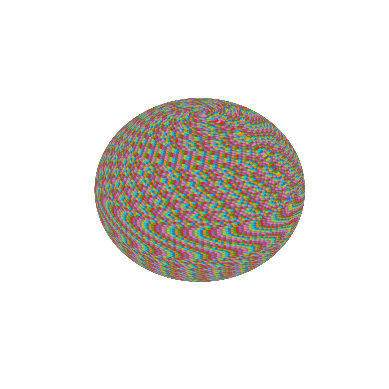

In [24]:
plotSkyMap3d(skymap_data)